# PROV W3C using the Python Library - first steps

The [PROV Python library](http://badge.fury.io/py/prov) is an implementation of the [Provenance Data Model](http://www.w3.org/TR/prov-dm/) by the World Wide Web Consortium. This notebook illustrates how to use the library to:

* create provenance statements in Python;
* export the provenance to [PROV-N](http://www.w3.org/TR/prov-n/), [PROV-JSON](https://provenance.ecs.soton.ac.uk/prov-json/), and graphical representations like PNG, SVG, PDF; and
* store and retrieve provenance on [ProvStore](https://provenance.ecs.soton.ac.uk/store).
* extend a data processing step with provenance tracing

(see also the python prov [introduction notebook](https://github.com/trungdong/notebooks), from which some parts are borrowed)

## Installation

To install the prov library using [pip](http://pip.pypa.io/) with support for graphical exports:
```bash
pip install prov[dot]
```


## Create a simple provenance document

In this example, we use the Data Journalism example from [Provenance: An Introduction to PROV](http://www.provbook.org/) by [Luc Moreau](http://www.ecs.soton.ac.uk/~lavm/) and [Paul Groth](http://www.few.vu.nl/~pgroth/). If you do not have access to the book, you can find the example from the [slides](http://www.provbook.org/tutorial/provenanceweek2014/prov-tutorial.pptx) by Luc and Paul (starting from slide #15). Please familarise yourself with the example and relevant PROV concepts (i.e. [entity](http://www.w3.org/TR/prov-primer/#entities), [activity](http://www.w3.org/TR/prov-primer/#activities), [agent](http://www.w3.org/TR/prov-primer/#agents-and-responsibility), ...) before proceeding with this tutorial.

To create a [provenance document](), import `ProvDocument` class from `prov.model`:

In [78]:
from prov.model import ProvDocument

In [90]:
# Create a new provenance document
d1 = ProvDocument()  # d1 is now an empty provenance document

Before asserting provenance statements, we need to have a way to refer to the "things" we want to describe provenance (e.g. articles, data sets, people). For that purpose, PROV uses [qualified names](http://www.w3.org/TR/prov-dm/#term-identifier) to identify things, which essentially a shortened representation of a [URI](http://en.wikipedia.org/wiki/Uniform_resource_identifier) in the form of `prefix:localpart`. Valid qualified names require their prefixes defined, which we is going to do next.

In [91]:
# Declaring namespaces for various prefixes used in the example
d1.add_namespace('enes', 'http://www.enes.org/enes_entitiy/')
d1.add_namespace('file', 'http://www.enes.org/enes_entity/file/')
d1.add_namespace('user', 'http://www.enes.org/enes_entity/user/')
#d1.add_namespace('bk', 'http://www.provbook.org/ns/#')
d1.add_namespace('esgf_http', 'http://carbon.dkrz.de/file/cmip5/')

<Namespace: esgf_http {http://carbon.dkrz.de/file/cmip5/}>

Now we can create things like entities, agents and relate them with one another.

In [92]:
# File(Collection) Entities:
e1 = d1.entity('esgf_http:cmip5.mpi-m.tas.v1')
r1 = d1.entity('enes:temporal-mean-result1-v1.nc')
# Agent: enes:experiment
d1.agent('user:stephan')

<ProvAgent: user:stephan>

The statements create input and output entities as well as an agent, responsible for creating the output

In [93]:
# Attributing the article to the agent
d1.wasAttributedTo(r1, 'user:stephan')

<ProvAttribution: (enes:temporal-mean-result1-v1.nc, user:stephan)>

In [94]:
# What we have so far (in PROV-N)
print d1.get_provn()

document
  prefix esgf_http <http://carbon.dkrz.de/file/cmip5/>
  prefix enes <http://www.enes.org/enes_entitiy/>
  prefix file <http://www.enes.org/enes_entity/file/>
  prefix user <http://www.enes.org/enes_entity/user/>
  
  entity(esgf_http:cmip5.mpi-m.tas.v1)
  entity(enes:temporal-mean-result1-v1.nc)
  agent(user:stephan)
  wasAttributedTo(enes:temporal-mean-result1-v1.nc, user:stephan)
endDocument


We can adds properties to the input, which is a `enes_data:Dataset` and has the label `experiment-mpi-m`. The entity's type and label are domain-specific information; similar information can be added to any record as the last argument of a statement (or as a keyword argument `other_attributes`).

The last statement below then asserts that the result output `enes:temporal-mean-result1-v1.nc` was derived from the data set.

In [95]:
# 'now:employment-article-v1.html' was derived from govftp

d1.add_namespace('enes_data', 'http://enes_org/enes_data#')
d1.add_namespace('dc','http://dublin-core.org/')
d1.entity('esgf_http:cmip5.mpi-m.tas.v1', {'prov:label': 'experiment-mpi-m', 'prov:type': 'enes_data:Dataset', 'dc:title':"dublin core title"})
d1.wasDerivedFrom('enes:temporal-mean-result1-v1.nc', 'esgf_http:cmip5.mpi-m.tas.v1')

<ProvDerivation: (enes:temporal-mean-result1-v1.nc, esgf_http:cmip5.mpi-m.tas.v1)>

In [96]:
print d1.get_provn()

document
  prefix enes <http://www.enes.org/enes_entitiy/>
  prefix dc <http://dublin-core.org/>
  prefix esgf_http <http://carbon.dkrz.de/file/cmip5/>
  prefix user <http://www.enes.org/enes_entity/user/>
  prefix file <http://www.enes.org/enes_entity/file/>
  prefix enes_data <http://enes_org/enes_data#>
  
  entity(esgf_http:cmip5.mpi-m.tas.v1)
  entity(enes:temporal-mean-result1-v1.nc)
  agent(user:stephan)
  wasAttributedTo(enes:temporal-mean-result1-v1.nc, user:stephan)
  entity(esgf_http:cmip5.mpi-m.tas.v1, [prov:type="enes_data:Dataset", dc:title="dublin core title", prov:label="experiment-mpi-m"])
  wasDerivedFrom(enes:temporal-mean-result1-v1.nc, esgf_http:cmip5.mpi-m.tas.v1, -, -, -)
endDocument


Following the example, we further extend the document with an activity, a usage, and a generation statement.

In [110]:
# Adding an activity
d1.add_namespace('workflow', 'http://www.enes.org/enes/workflow/#')

d1.activity('workflow:temporal-mean-cdo','2012-03-31T09:21:00', '2012-04-01T15:21:00',{'dc:title':"dublin core title"})


<ProvActivity: workflow:temporal-mean-cdo>

In [111]:
# Usage and Generation
d1.used('workflow:temporal-mean-cdo', 'esgf_http:cmip5.mpi-m.tas.v1')
d1.wasGeneratedBy('enes:temporal-mean-result1-v1.nc', 'workflow:temporal-mean-cdo')

<ProvGeneration: (enes:temporal-mean-result1-v1.nc, workflow:temporal-mean-cdo)>

## Graphics export (PNG and PDF)

In addition to the PROV-N output (as above), the document can be exported into a graphical representation with the help of the [GraphViz](http://www.graphviz.org/). It is provided as a software package in popular Linux distributions, or can be [downloaded](http://www.graphviz.org/Download.php) for Windows and Mac.

Once you have GraphViz installed and the `dot` command available in your operating system's paths, you can save the document we have so far into a PNG file as follows.

In [112]:
# visualize the graph
from prov.dot import prov_to_dot
dot = prov_to_dot(d1)
dot.write_png('enes-prov1.png')

True

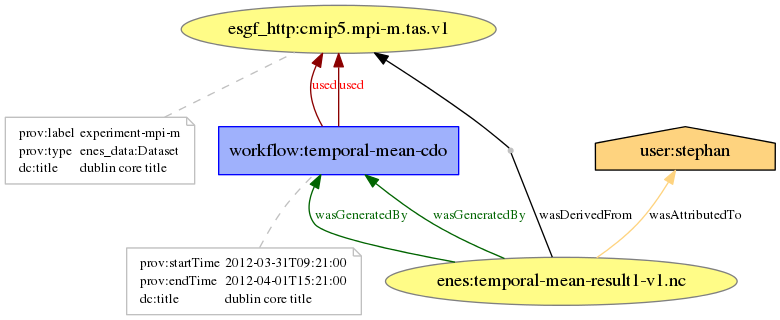

In [113]:
from IPython.display import Image
Image('enes-prov1.png')

The above saves the PNG file as `article-prov.png` in your current folder. If you're runing this tutorial in Ipython Notebook, you can display it as well.

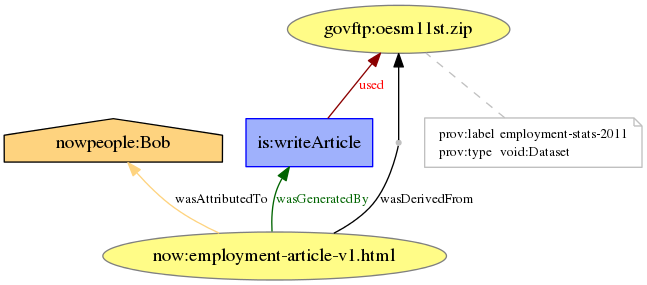

In [11]:
from IPython.display import Image
Image('article-prov.png')

In [12]:
# Or save to a PDF
dot.write_pdf('article-prov.pdf')

True

Similarly, the above saves the document into a PDF file in your current working folder. Graphviz supports a wide ranges of [raster and vector outputs](http://www.graphviz.org/doc/info/output.html), to which you can export your provenance documents created by the library. To find out what formats are available from your version, run `dot -T?` at the command line.

## PROV-JSON export

[PROV-JSON](https://provenance.ecs.soton.ac.uk/prov-json/) is natively supported by the library and is the default serialisation format.

In [65]:
print d1.serialize(indent=2)

{
  "wasDerivedFrom": {
    "_:id2": {
      "prov:usedEntity": "esgf_http:cmip5.mpi-m.tas.v1", 
      "prov:generatedEntity": "enes:temporal-mean-result1-v1.nc"
    }
  }, 
  "used": {
    "_:id3": {
      "prov:entity": "esgf_http:cmip5.mpi-m.tas.v1", 
      "prov:activity": "workflow:temporal-mean-cdo"
    }
  }, 
  "wasAttributedTo": {
    "_:id1": {
      "prov:entity": "enes:temporal-mean-result1-v1.nc", 
      "prov:agent": "user:stephan_kindermann_at_gmail.com"
    }
  }, 
  "agent": {
    "user:stephan_kindermann_at_gmail.com": {}
  }, 
  "entity": {
    "enes:temporal-mean-result1-v1.nc": {}, 
    "esgf_http:cmip5.mpi-m.tas.v1": [
      {}, 
      {
        "prov:type": "enes_data:Dataset", 
        "prov:label": "experiment-mpi-m"
      }
    ]
  }, 
  "prefix": {
    "enes": "http://www.enes.org/enes_entitiy/", 
    "workflow": "http://www.enes.org/enes/workflow/#", 
    "bk": "http://www.provbook.org/ns/#", 
    "esgf_http": "http://carbon.dkrz.de/file/cmip5/", 
    "user"

You can also serialize the document directly to a file by providing a filename (below) or a Python File object.

In [14]:
d1.serialize('article-prov.json')

A PROV-JSON file can also be deserialised into a `ProvDocument` instance as follows.

In [15]:
d2 = ProvDocument.deserialize('article-prov.json')
d1 == d2  # Is it the same document we saved earlier?

True

## Store and retrieve provenance documents from ProvStore

Having the created a provenance document, you can upload it to [ProvStore](https://provenance.ecs.soton.ac.uk/store/), a free repository for provenance documents, to share it publicly/privately, or simple just to store and retrieve it back at a later time.
In addition to storage and sharing, you can also retrieve your documents on ProvStore in further formats like XML and RDF, transform, and/or visualise them in various ways (see [this poster](http://eprints.soton.ac.uk/365509/) for more information).

Before storing your document there, you need to [register for an account](https://provenance.ecs.soton.ac.uk/store/account/signup/). You can then upload the PROV-N or PROV-JSON export above via ProvStore's website. However, if you [generated an API Key](https://provenance.ecs.soton.ac.uk/store/account/developer/) for your account, you can also upload the document there directly from this tutorial as shown below.

A wrapper for [ProvStore's REST API](https://provenance.ecs.soton.ac.uk/store/help/api/) is provided by the package [provstore-api](https://github.com/millar/provstore-api#installation). Please follow the [installation instructions](https://github.com/millar/provstore-api#installation) there before proceeding.

In [17]:
# Configure ProvStore API Wrapper with your API Key
from provstore.api import Api
# see your API key at https://provenance.ecs.soton.ac.uk/store/account/developer/
api = Api(username='your ProvStore username', api_key='your API key')

In [18]:
# Submit the document to ProvStore
provstore_document = api.document.create(d1, name='article-prov', public=True)

# Generate a nice link to the document on ProvStore so you don't have to find it manually 
from IPython.display import HTML
document_uri = provstore_document.url
HTML('<a href="%s" target="_blank">Open your new provenance document on ProvStore</a>' % document_uri)

The first statement above submit the document `d1` to ProvStore, giving it a name (required) and making it visible to everyone (optional and private by default). Clicking on the link generated will open the page on ProvStore for the document you just submitted.

The returned object is a wrapper for the document on ProvStore identified by `provstore_document.id`, with which you can, of course, retrieve the document again from ProvStore.

In [19]:
# Retrieve it back
retrieved_document = api.document.get(provstore_document.id)
d2 = retrieved_document.prov
d1 == d2  # Is it the same document we submitted?

True

You can also remove the document from ProvStore via its API. It is a good idea to leave your account there nice and tidy anyway.

In [20]:
# Cleaning up, delete the document
retrieved_document.delete()

True

In [77]:
# Just to be sure, trying to retrieve it again
#api.document.get(provstore_document.id)  # the document is no longer there

## Further reading

There it is, through a very short tutorial, you have managed to create a provenance document, export it, and store it on the cloud. Simple!

If you want to find out more about how to use the library and ProvStore, here are some references:
* [Prov Python library's documentation](http://prov.readthedocs.org)
* [ProvStore's API documentation](https://provenance.ecs.soton.ac.uk/store/help/api/)
* Book: [Provenance: An Introduction to PROV](http://www.provbook.org/)
* [Overview of the PROV standards](http://www.w3.org/TR/prov-overview/)

Finally, if you have issues with the Prov Python library, please report them at our [issue tracker on Github](https://github.com/trungdong/prov/issues).

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" href="http://purl.org/dc/dcmitype/InteractiveResource" property="dct:title" rel="dct:type"> PROV W3C using the Python Library - first steps</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://about.me/stephan.kindermann" property="cc:attributionName" rel="cc:attributionURL"/></a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.